In [8]:
# initializing the pca
import cv2 as cv

from skimage import io,measure,filters,morphology,transform
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

In [9]:
def return_exp(path):
    return [p.split('_')[0] for p in path.split('/') if 'LH' in p][0]

def return_well(path):
    return [p.split('_')[1] for p in path.split('/') if 'LH' in p][0]

def return_block(path):
    return [int(p.lower().split('block')[1]) for p in path.split('/') if 'block' in p.lower()][0]

In [10]:
# Load ROI info
path_to_archive = '/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Data/archive.txt'
path_output = '/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Data/aggregate_measurements.csv'
archive = pd.read_csv(path_to_archive,header=None,names=['id','path','ROI-block-index','pixel_size'])
archive['exp'] = archive.path.apply(return_exp)
archive['well'] = archive.path.apply(return_well)
archive['block'] = archive.path.apply(return_block)
archive['ROI-index'] = archive.groupby(['exp','well','block','ROI-block-index']).ngroup().astype(str)
archive.head(5)

,id,path,ROI-block-index,pixel_size,exp,well,block,ROI-index
0,0,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,0,4.230,LH01,A01,1,0
1,1,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,1,4.230,LH01,A01,1,1
2,2,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,2,3.136,LH01,A01,1,2
3,3,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,3,3.136,LH01,A01,1,3
4,4,/Users/lukasvandenheuvel/Documents/EPFL/MA4/P...,4,3.136,LH01,A01,1,4


In [11]:
def right_hand_triangle_treshold(img,num_bins=256):
    # Right-hand triangle threshold
    # Right-hand triangle threshold
    #H = cv.calcHist([img],[0],None,[num_bins],[img.min(),img.max()])
    #H_centers = np.linspace(img.min(),img.max(),num_bins)
    H,H_centers = np.histogram(img.flatten(), bins=num_bins, range=[img.min(), img.max()])
    m = 1 + np.argmax(H[1:]) # Omit first histogram entry because we don't want the max to be at 0
    linear_decline = np.linspace(H[m],H[-1],len(H)-m)
    d = np.sqrt((linear_decline - H[m:]) **2 / 2 ) # distances between histogram and linear decline
    return H_centers[m + np.argmax(d)]

In [6]:
nr = 13

min_size_nm = 200 * (3000/2048)**2
sigmas = [1,2,3,4]
black_ridges = True
df = pd.DataFrame(index=archive.index,columns=['ridge_surface','dense_surface','nr'])

roi_path = os.path.dirname(archive.loc[nr,'path'].strip())
path_metadata = os.path.join(roi_path,'hmEM_metadata.txt')
path_em = os.path.join(roi_path,'hmEM.tif')
path_mask = os.path.join(roi_path,'hmEM_mask.tif')
pixel_size = archive.loc[nr,'pixel_size']
min_size = np.round(min_size_nm / (pixel_size**2))
print(f"Img nr {nr}: min object size = {min_size} pixels")

# Read image and mask
em_img = io.imread(path_em)
mask = io.imread(path_mask)==255    

Img nr 13: min object size = 72.0 pixels


In [14]:
min_size_nm

858.306884765625

In [13]:
nrs = [74]

min_size_nm = 100 * (3000/1024)**2
sigmas = [1,2,3,4]
black_ridges = True
df = pd.DataFrame(index=archive.index,columns=['ridge_surface','dense_surface','nr'])

for nr in nrs:

    roi_path = os.path.dirname(archive.loc[nr,'path'].strip())
    path_metadata = os.path.join(roi_path,'hmEM_metadata.txt')
    path_em = os.path.join(roi_path,'hmEM.tif')
    path_mask = os.path.join(roi_path,'hmEM_mask.tif')
    pixel_size = archive.loc[nr,'pixel_size']
    min_size = np.round(min_size_nm / (pixel_size**2))
    print(f"Img nr {nr}: min object size = {min_size} pixels")

    # Read image and mask
    em_img = io.imread(path_em)
    mask = io.imread(path_mask)==255    

    # Crop out the aggregate
    y_coords,x_coords = np.nonzero(mask)
    min_x,max_x = (x_coords.min(),x_coords.max())
    min_y,max_y = (y_coords.min(),y_coords.max())
    em_crop     = em_img[min_y:max_y,min_x:max_x]
    mask_crop   = mask[min_y:max_y,min_x:max_x]

    # Calculate density by Otsu thresholding
    em_norm = (em_crop - em_crop[mask_crop].mean()) / em_crop[mask_crop].std()
    em_inv  = em_norm.max() - em_norm
    em_inv_gauss = filters.gaussian(em_inv,sigma=2)
    em_otsu = (em_inv_gauss > filters.threshold_otsu(em_inv_gauss[mask_crop]))
    em_otsu[~mask_crop] = 0

    # Detect ridges using Meijering thresholding
    meij = filters.meijering(em_norm,sigmas=sigmas,black_ridges=black_ridges)
    thr = (meij > right_hand_triangle_treshold(meij[mask_crop]))
    thr[~mask_crop] = 0
    thr_clean = morphology.remove_small_objects(thr, min_size=min_size)
    
    out_thr = np.zeros(em_img.shape,dtype=bool)
    out_thr[min_y:max_y,min_x:max_x] = thr_clean
    io.imsave(os.path.join(roi_path,'hmEM_ridges.tif'),out_thr)

    out_otsu = np.zeros(em_img.shape,dtype=bool)
    out_otsu[min_y:max_y,min_x:max_x] = em_otsu
    io.imsave(os.path.join(roi_path,'hmEM_otsu.tif'),out_otsu)


    df.loc[nr,'nr']             = nr
    df.loc[nr,'area_pixel']     = mask_crop.sum()
    df.loc[nr,'pixel_size']     = archive.loc[nr,'pixel_size']
    df.loc[nr,'ridge_surface']  = thr_clean.sum() / mask_crop.sum() 
    df.loc[nr,'dense_surface']  = em_otsu.sum() / mask_crop.sum()

# df.to_csv(path_output)

Img nr 74: min object size = 147.0 pixels


/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_21124/665338526.py:44: UserWarning: /Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Data/LH02_A03/block1/cycle8_ROI1/hmEM_ridges.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(roi_path,'hmEM_ridges.tif'),out_thr)
/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_21124/665338526.py:44: UserWarning: /Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Data/LH02_A03/block1/cycle8_ROI1/hmEM_ridges.tif is a low contrast image
  io.imsave(os.path.join(roi_path,'hmEM_ridges.tif'),out_thr)
/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_21124/665338526.py:48: UserWarning: /Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/Data/LH02_A03/block1/cycle8_ROI1/hmEM_otsu.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  io.imsave(os.path.join(r

In [8]:
df['ridge_surface_perc'] = df['ridge_surface'] * 100
df['dense_surface_perc'] = df['dense_surface'] * 100
to_plot = df[['ridge_surface_perc','dense_surface_perc','nr']].merge(archive['ROI-index'],left_index=True,right_index=True)

fig = px.scatter(to_plot,x='dense_surface_perc',y='ridge_surface_perc',hover_data='nr',width=600, height=500,
                 labels=dict(dense_surface_perc="Dense surface (%)", ridge_surface_perc="Ridge surface (%)")
)

fig.update_layout({
    'plot_bgcolor': 'rgba(255,255,255,1)',
    'paper_bgcolor': 'rgba(255,255,255,1)',
    'xaxis': dict(
        zeroline = False,
        showgrid = False,
        tickmode = 'linear',
        tick0 = 0,
        dtick = 10,
        showline=True,
        linewidth = 1,
        linecolor='black'
    ),
    'yaxis': dict(
        zeroline = False,
        showgrid = False,
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1,
        showline=True,
        linewidth = 1,
        linecolor='black'
    )
})

#fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
#fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()

In [4]:
# Load images
path = '/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/EM_snapshots'
out_path = '/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/EM_snapshots_edges'
img_shape = 1024
files = os.listdir(path)
img_dict = {}
for f in files:
    if "img" in f:
        nr = int(f.split("img")[1].split(".tif")[0])
        img_dict[nr] = np.array(transform.resize(io.imread(os.path.join(path,f)),(img_shape,img_shape)), dtype=np.float32)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offs

In [6]:
def right_hand_triangle_treshold(img,num_bins=256):
    # Right-hand triangle threshold
    # Right-hand triangle threshold
    H = cv.calcHist([img],[0],None,[num_bins],[img.min(),img.max()])
    H_centers = np.linspace(img.min(),img.max(),num_bins)
    m = 1 + np.argmax(H[1:]) # Omit first histogram entry because we don't want the max to be at 0
    linear_decline = np.linspace(H[m],H[-1],len(H)-m)
    d = np.sqrt((linear_decline - H[m:]) **2 / 2 ) # distances between histogram and linear decline
    return H_centers[m + np.argmax(d)]

In [7]:
# Helper function for calculating entropy
def entp(x):
    temp = np.multiply(x, np.log(x))
    temp[np.isnan(temp)] = 0
    return temp

def max_entropy_threshold(img,num_bins=256):
    # Maximum entropy
    H = cv.calcHist([img],[0],None,[num_bins],[img.min(),img.max()])
    H_centers = np.linspace(img.min(),img.max(),num_bins)
    H = H / np.sum(H)

    theta = np.zeros(num_bins)
    Hf = np.zeros(num_bins)
    Hb = np.zeros(num_bins)

    for T in range(1,num_bins-1):
        Hf[T] = - np.sum( entp(H[:T-1] / np.sum(H[1:T-1])) )
        Hb[T] = - np.sum( entp(H[T:] / np.sum(H[T:])) )
        theta[T] = Hf[T] + Hb[T]

    theta_max = H_centers[np.argmax(theta)]
    return theta_max


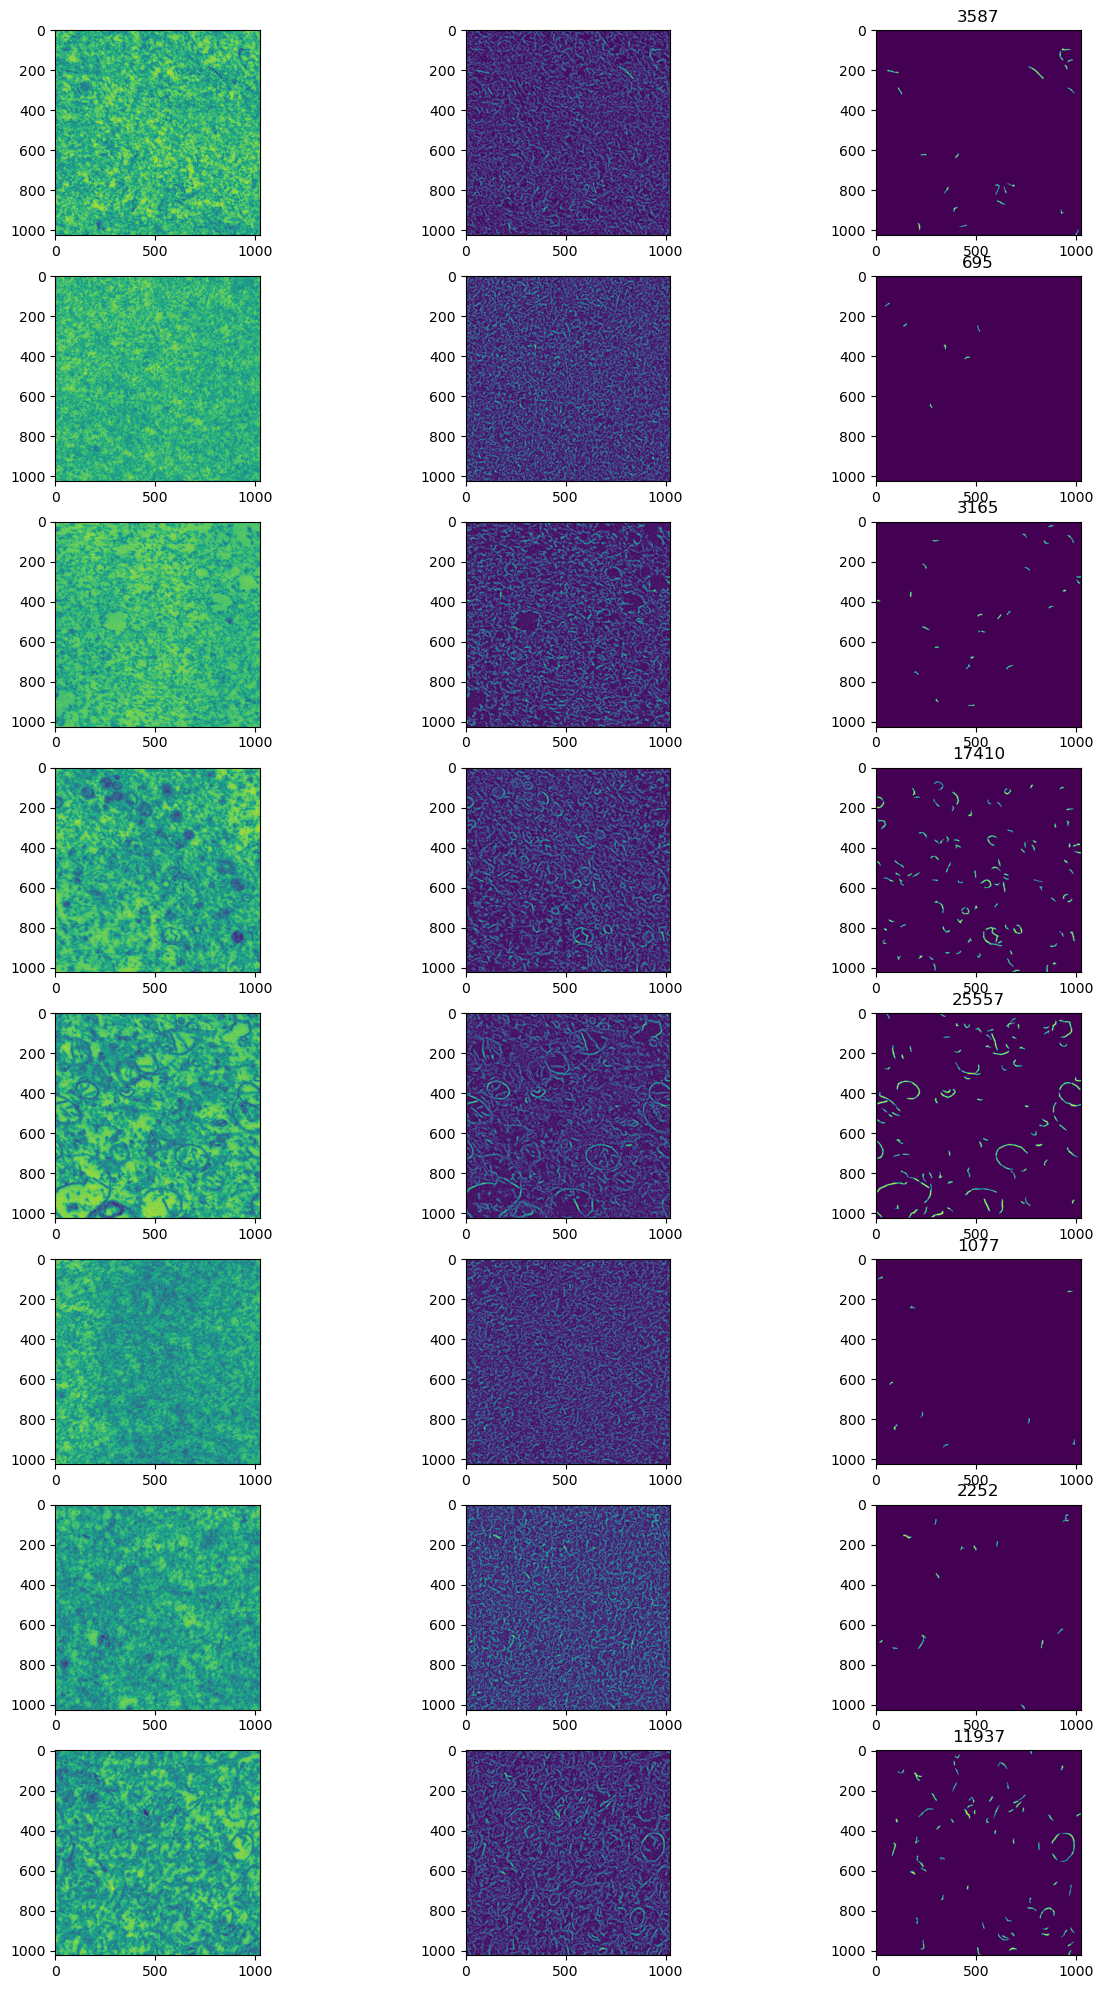

In [9]:
num_images = 8
min_size = 100
sigmas = [1,2,3,4]
black_ridges = True

fig,ax = plt.subplots(num_images,3,figsize=(15,25))
random_nrs = np.random.randint(0,len(img_dict),num_images)
random_nrs[0] = 51

for i in range(num_images):
    nr = random_nrs[i]
    img = img_dict[nr]
    img_norm = (img - img.mean()) / img.std()
    meij = filters.meijering(img_norm,sigmas=sigmas,black_ridges=black_ridges)

    ax[i,0].imshow(img_norm)
    ax[i,1].imshow(meij)
    thr = (meij > right_hand_triangle_treshold(meij))
    thr_clean = morphology.remove_small_objects(thr, min_size=min_size)
    # labels = measure.label(thr_clean,connectivity=2)
    # ridge_sizes = np.array([(labels==l).sum() for l in np.arange(1,np.max(labels))])
    ax[i,2].imshow(thr_clean)
    ax[i,2].set_title(thr_clean.sum())


In [10]:
sigmas = [1,2,3,4]
min_size = 100

df = pd.DataFrame(index=img_dict.keys(),columns=['ridge_surface','dense_surface','nr'])
for nr,img in img_dict.items():
    img_norm = (img - img.mean()) / img.std()
    img_inv  = img_norm.max()-img_norm
    img_inv_gauss = filters.gaussian(img_inv,sigma=1.5)
    density = (img_inv_gauss > filters.threshold_otsu(img_inv_gauss)).sum() / (img_shape*img_shape)

    meij = filters.meijering(img_norm,sigmas=sigmas,black_ridges=black_ridges)
    thr = (meij > right_hand_triangle_treshold(meij))
    thr_clean = morphology.remove_small_objects(thr, min_size)
    
    df.loc[nr,'ridge_surface']  = thr_clean.sum() / (img_shape*img_shape) # scale #(ridge_sizes>large_ridge_size).sum() / len(ridge_sizes)
    df.loc[nr,'dense_surface']  = density
    df.loc[nr,'nr']             = nr

In [94]:
# Run this if you want to sort images by some quantity

# out_path = '/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/sorted'
# sorted = df.sort_values(by='ridge_size')
# for i,ind in enumerate(sorted.index):
#     io.imsave(os.path.join(out_path,f'sort{i}_img{ind}.tif'),img_dict[ind])

/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_11336/3408844209.py:4: UserWarning:

/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/sorted/sort0_img14.tif is a low contrast image

/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_11336/3408844209.py:4: UserWarning:

/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/sorted/sort1_img8.tif is a low contrast image

/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_11336/3408844209.py:4: UserWarning:

/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/sorted/sort2_img5.tif is a low contrast image

/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_11336/3408844209.py:4: UserWarning:

/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/sorted/sort3_img24.tif is a low contrast image

/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc0000gn/T/ipykernel_11336/3408844209.py:4: UserWarning:

/Users/lukasvandenheuvel/Documents/EPFL/MA4/PDM/sorted/sort4_img84.tif is a low contrast image

/var/folders/0z/hvg4mzl50gqb0m2ql3c0w0xc00

In [12]:
plot_unique_aggregates_only = True
unique_ids = [0,2,3,4,5,6,7,8,10,14,15,16,18,23,24,27,31,33,34,35,36,39,40,43,49,51,54,55,56,57,59,60,61,63,65,67,74,75,76,77,81,83,84]

In [13]:
df['ridge_surface_perc'] = df['ridge_surface'] * 100
df['dense_surface_perc'] = df['dense_surface'] * 100

to_plot = df[['ridge_surface_perc','dense_surface_perc','nr']].merge(archive['ROI-index'],left_index=True,right_index=True)
if plot_unique_aggregates_only:
    to_plot = to_plot.loc[unique_ids]

fig = px.scatter(to_plot,x='dense_surface_perc',y='ridge_surface_perc',hover_data='nr',width=600, height=500,
                 labels=dict(dense_surface_perc="Dense surface (%)", ridge_surface_perc="Ridge surface (%)")
)

fig.update_layout({
    'plot_bgcolor': 'rgba(255,255,255,1)',
    'paper_bgcolor': 'rgba(255,255,255,1)',
    'xaxis': dict(
        zeroline = False,
        showgrid = False,
        tickmode = 'linear',
        tick0 = 0,
        dtick = 10,
        showline=True,
        linewidth = 1,
        linecolor='black'
    ),
    'yaxis': dict(
        zeroline = False,
        showgrid = False,
        tickmode = 'linear',
        tick0 = 0,
        dtick = 1,
        showline=True,
        linewidth = 1,
        linecolor='black'
    )
})

#fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
#fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.show()